# IRC Behavioral Analysis

### Imports

In [1]:
import zat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from zat.log_to_dataframe import LogToDataFrame
from zat.bro_log_reader import BroLogReader
from collections import defaultdict
from textblob import TextBlob
import pycountry
from collections import defaultdict
from itertools import chain
import re
import itertools
from Levenshtein import distance as levenshtein_distance
from multiprocessing import Pool

## Loading Data

In [21]:
import os

log_names_mal = ['03','04','34','39','42','51','56','62']
log_names_benign = ['irc1']
log_names = log_names_mal + log_names_benign

project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/'
# project_dir = '/home/prenek/IRC-Behavioral-Analysis/'
log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')

fileout_join_freq = 'join_freq.log'
fileout_lev_dist = 'lev_dist.log'

logs_fn_join = [os.path.join(log_dir,l,'irc_join.log') for l in log_names]
logs_fn_join_mal = [os.path.join(log_dir,l,'irc_join.log') for l in log_names_mal]
logs_fn_join_benign = [os.path.join(log_dir,l,'irc_join.log') for l in log_names_mal]

logs_fn_privmsg = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names]
logs_fn_privmsg_mal = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names_mal]
logs_fn_privmsg_benign = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names_benign]

logs_fn_channelinfo = [os.path.join(log_dir,l,'irc_channelinfo.log') for l in log_names]
logs_fn_channelinfo_mal = [os.path.join(log_dir,l,'irc_channelinfo.log') for l in log_names_mal]
logs_fn_channelinfo_benign = [os.path.join(log_dir,l,'irc_channelinfo.log') for l in log_names_benign]

logs_fn_networkinfo = [os.path.join(log_dir,l,'irc_networkinfo.log') for l in log_names]
logs_fn_networkinfo_mal = [os.path.join(log_dir,l,'irc_networkinfo.log') for l in log_names_mal]
logs_fn_networkinfo_benign = [os.path.join(log_dir,l,'irc_networkinfo.log') for l in log_names_benign]

In [22]:
def load_logs(file):
    logs_arr = []
    if not os.path.isfile(file):
        return logs_arr
    
    reader = BroLogReader(file)
    for log in reader.readrows():
        # log is in dictionary format
        logs_arr.append(log)

    return logs_arr

In [23]:
logs_join_mal = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join_benign = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join = logs_join_mal + logs_join_benign

logs_privmsg_mal = list(map(lambda x: load_logs(x),logs_fn_privmsg_mal))
logs_privmsg_mal = [list(filter(lambda x: x['target'].startswith('#'), log)) for log in logs_privmsg_mal]
logs_privmsg_benign = list(map(lambda x: load_logs(x), logs_fn_privmsg_benign))
logs_privmsg_benign = [list(filter(lambda x: x['target'].startswith('#'), log)) for log in logs_privmsg_benign]
logs_privmsg = logs_privmsg_mal + logs_privmsg_benign

logs_channelinfo_mal = list(map(lambda x: load_logs(x), logs_fn_channelinfo_mal))
logs_channelinfo_benign = list(map(lambda x: load_logs(x), logs_fn_channelinfo_benign))
logs_channelinfo = logs_channelinfo_mal + logs_channelinfo_benign


logs_networkinfo_mal = list(map(lambda x: load_logs(x), logs_fn_networkinfo_mal))
logs_networkinfo_benign = list(map(lambda x: load_logs(x), logs_fn_networkinfo_benign))
logs_networkinfo = logs_networkinfo_mal + logs_networkinfo_benign

Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/04/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/34/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/39/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/42/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/51/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/56/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/zeek/logs/62/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratos

### Divide logs by channels

In [24]:
from collections import defaultdict
logs_join_divided = []
for logs in logs_join:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['channel']].append(log)
    logs_join_divided.append(logs_per_channel)

In [25]:
logs_privmsg_benign_divided = []
for logs in logs_privmsg_benign:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['target']].append(log)
    logs_privmsg_benign_divided.append(logs_per_channel)

In [26]:
logs_privmsg_mal_divided = []
for logs in logs_privmsg_mal:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['target']].append(log)
    logs_privmsg_mal_divided.append(logs_per_channel)

## Number of Users in Channel per Day

In [35]:
df_mal = pd.DataFrame(columns=['pcap','channel'])
for ln, logs_div in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs_div:
        df_mal = df_mal.append({'pcap': ln, 'channel':channel}, ignore_index=True)

df_benign = pd.DataFrame(columns=['pcap','channel'])
for ln, logs_div in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs_div:
        df_benign = df_benign.append({'pcap': ln, 'channel':channel}, ignore_index=True)

df_mal.head()
# df_benign.head()

,pcap,channel
0,34,##Summit
1,42,#Runz
2,51,#007
3,51,#all
4,51,#kz


In [23]:
# import json

# def ircjoin_compute(logs):
#     if len(logs) == 0:
#         return None, None

#     logs_ts = list(map(lambda x: x['ts'].date(), logs))

#     # first ts of join command
#     ts_min = min(logs_ts)
#     ts_max = max(logs_ts)
# #     print('min date: {}, max date: {}'.format(ts_min, ts_max))
#     span = ts_max - ts_min
    
#     dates = [ts_min+timedelta(days=i) for i in range(span.days+1)]

#     ## count how many join commands are in which day 
#     logs_per_day = defaultdict(lambda: 0)
#     for v in logs_ts:
#         logs_per_day[v] += 1
    
#     dates_count = []
#     count = 0
#     for d in dates:
#         count += logs_per_day[d]
#         dates_count.append(count)
    
#     return dates, dates_count


# def ircjoin_visualize(dates, dates_count):
#     plt.bar(dates,dates_count)
#     plt.show()

### Data export into CSV

In [24]:
# print('ircjoin...')
# for ln, l in zip(log_names, logs_join_divided):
#    fn = os.path.join(out_dir, ln, fileout_join_freq)
#    df_join = pd.DataFrame(columns=['channel','date','users_count'])
   
#    for l_k in l.keys():
#        log = l[l_k]
#        d_arr, dc_arr = ircjoin_compute(log)
#        # ircjoin_visualize(d, dc)
#        for d, dc in zip(d_arr,dc_arr):
#            df_join = df_join.append({'channel': l_k, 'date': d, 'users_count': dc}, ignore_index=True)
   
#    print(fn)
#    df_join.to_csv(fn, sep=';', encoding='utf-8')

ircjoin...
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/03/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/04/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/34/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/39/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/42/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/51/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/56/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/62/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/irc1/join_freq.log


### Reading exported all csv and merging it into one 

In [108]:
# print('ircjoin...')
# df_join = pd.DataFrame(columns=['channel','date','users_count', 'pcap', 'malicious'])
# for ln in log_names_mal:
#     fn = os.path.join(out_dir, ln, fileout_join_freq)
#     df_join_tmp = pd.read_csv(fn, sep=';', encoding='utf-8')
   
#     for i, df_el in df_join_tmp.iterrows():
#         df_join = df_join.append({'channel': df_el['channel'],
#                                   'date': df_el['date'],
#                                   'users_count': df_el['users_count'],
#                                   'pcap': ln,
#                                   'malicious': 1
#                                  }, ignore_index=True)
   
# for ln in log_names_benign:
#     fn = os.path.join(out_dir, ln, fileout_join_freq)
#     df_join_tmp = pd.read_csv(fn, sep=';', encoding='utf-8')
#     for i, df_el in df_join_tmp.iterrows():
#         df_join = df_join.append({'channel': df_el['channel'],
#                                       'date': df_el['date'],
#                                       'users_count': df_el['users_count'],
#                                       'pcap': ln,
#                                       'malicious': 0
#                                      }, ignore_index=True)
df_join = pd.read_csv(os.path.join(out_dir, 'join_freq_all.csv'))
df_join.drop('Unnamed: 0', axis=1, inplace=True)
df_join.head()

users_join_arr = []
for ln, logs_div in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs_div:
        m = df_join[(df_join['pcap'] == ln) & (df_join['channel'] == channel)]['users_count']
        users_join_arr.append(None if len(m) == 0 else max(m))

df_mal['users_join_max'] = users_join_arr
# df_mal.head()


users_join_arr = []
for ln, logs_div in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs_div:
        m = df_join[(df_join['pcap'] == ln) & (df_join['channel'] == channel)]['users_count']
        users_join_arr.append(None if len(m) == 0 else max(m))

df_benign['users_join_max'] = users_join_arr
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max
0,irc1,#worldchat,201,201,0.022353,689.0
1,irc1,#amigacs,6,6,0.001194,13.0
2,irc1,#sscait,1,1,0.000065,44.0
3,irc1,#networker,70,70,0.013757,820.0
4,irc1,#red_rulz,11,11,0.003070,27.0


## Creating a DataFrame for saving all features

## Levenshtein Distance of Messages in Channel

In [69]:
def compute_levenshtein_distance(logs_msg):
    combs = itertools.combinations(logs_msg, 2)
    dist_lev_arr = []
    for msg1, msg2 in combs:
        dist_lev_arr.append(levenshtein_distance(msg1,msg2))
#     return dt_lev_arr

### Bubble plot

In [109]:
# n = len(logs_privmsg_divided)

# print('ircprivmsg..')

# def compute_lev_dist_per_channel(fn, l_k):
#     print('channel: ', l_k)
#     # compute levenshtein distance
#     logs_msg = [log['msg'] for log in logs_div[l_k]]
#     logs_lev_dist = compute_levenshtein_distance(logs_msg)
#     # compute number of msg's senders per channel
#     sources = set([log['source'] for log in logs_div[l_k]])
#     print('sources: ', len(sources))

#     df = pd.DataFrame([{'channel': l_k, 'num_sources': len(sources), 'lev_dist': logs_lev_dist}])
    

#     if not os.path.isfile(fn):
#         print('creating csv file....')
#         df.to_csv(fn, header='column_names')
#     else:
#         print('csv file exists.')
#         df.to_csv(fn, mode='a', header=False)

#     return df


# for ln, logs_div in zip(log_names_benign, logs_privmsg_divided):
#     with Pool() as pool:
#         fn = os.path.join(out_dir, ln, fileout_lev_dist)
#         # loop through channels            
#         data = pool.starmap(compute_lev_dist_per_channel, itertools.product([fn], logs_div.keys()))   
import ast
df_lev_mal = pd.read_csv(os.path.join(out_dir, 'lev_dist_mal.csv'))
df_lev_mal.drop('Unnamed: 0', axis=1, inplace=True)
df_lev_mal['lev_dist'] =  df_lev_mal['lev_dist'].apply(lambda x: ast.literal_eval(x))
# df_lev_mal.head()

df_mal['lev_dist_mean'] = df_lev_mal['lev_dist'].apply(lambda x: np.mean(x))
df_mal['lev_dist_std'] = df_lev_mal['lev_dist'].apply(lambda x: np.std(x))
df_mal.head()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max
0,34,##Summit,46.579578,27.772919,English,0.015128,0,8.103709,6,NaN,31
1,42,#Runz,NaN,NaN,Unidentified,NaN,0,-0.000000,1,NaN,2
2,51,#007,28.437374,15.612790,English,0.025560,0,4.820940,3,1.0,12
3,51,#all,25.240929,19.280299,English,0.002190,0,4.278526,4,2462.0,7
4,51,#kz,33.619459,33.149611,English,NaN,0,5.244206,2,233.0,2


In [111]:
for pcap, log in zip(log_names_benign, logs_fn_privmsg_benign):
    # read line by line
    for i, df_el in enumerate(pd.read_csv(log, chunksize=1)):
        el = None
        try:
            el = np.array(ast.literal_eval(df_el['lev_dist'].iloc[0]))
            df_benign.iloc[i]['lev_dist_mean'] = np.mean(el)
            df_benign.iloc[i]['lev_dist_std'] = np.std(el)
        except:
            del el
            continue

In [112]:
## check if the rows are the same for the pandas
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max
0,irc1,#worldchat,201,201,0.022353,689.0
1,irc1,#amigacs,6,6,0.001194,13.0
2,irc1,#sscait,1,1,0.000065,44.0
3,irc1,#networker,70,70,0.013757,820.0
4,irc1,#red_rulz,11,11,0.003070,27.0


## Channel Language Recognition

In [113]:
## Create a text corpus for each file
def load_corpus(logs, pcap):
    corp_ch = set(filter(lambda x: len(x) > 2, chain.from_iterable(chain.from_iterable(map(lambda x: [re.findall(r"[a-zA-Z]+", w) for w in x['msg'].split()], logs)))))
    return corp_ch

## Malicious Samples

Compute message corpus per each channels

In [114]:
# logs_in = logs_privmsg_mal_divided
# load_corpus(logs_in)
corpus_df_mal = pd.DataFrame(columns=['pcap','corpus','lang'])
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        corpus = load_corpus(logs[channel], ln)
        corpus_df_mal = corpus_df_mal.append({'pcap': ln, 'channel': channel, 'corpus': corpus}, ignore_index=True)

Detect languages

In [115]:
for i, c in corpus_df_mal.iterrows():
    pcap = c['pcap']
    text = " ".join(c['corpus'])
    lang = "Unidentified"
    if len(text) > 2:
        code = TextBlob(text).detect_language()
        lang = pycountry.languages.get(alpha_2=code).name
    corpus_df_mal.iloc[i]['lang'] =  lang

In [116]:
df_mal['lang'] = corpus_df_mal['lang']
df_mal.head()

,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max
0,34,##Summit,46.579578,27.772919,English,0.015128,0,8.103709,6,NaN,31
1,42,#Runz,NaN,NaN,Unidentified,NaN,0,-0.000000,1,NaN,2
2,51,#007,28.437374,15.612790,English,0.025560,0,4.820940,3,1.0,12
3,51,#all,25.240929,19.280299,English,0.002190,0,4.278526,4,2462.0,7
4,51,#kz,33.619459,33.149611,English,NaN,0,5.244206,2,233.0,2


### Plotbar - channels

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

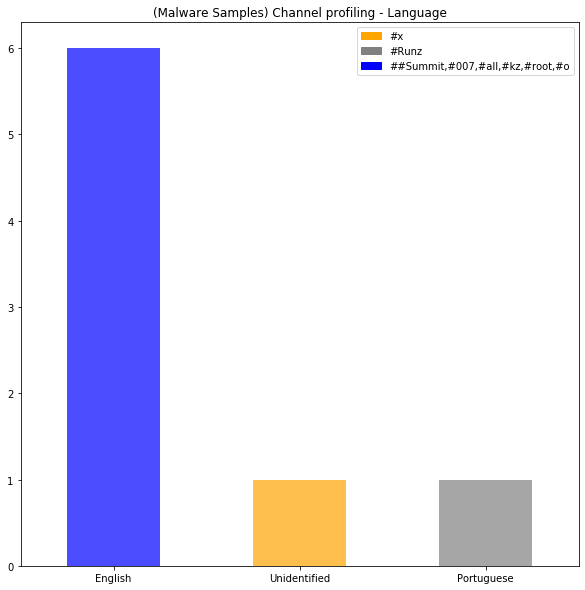

In [53]:
# # corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(10,10))

myplot = corpus_df_mal['lang'].value_counts().plot(kind='bar', color =['blue','orange','gray'], title='(Malware Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches
POR = mpatches.Patch(color='orange', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'Portuguese']['channel'])))
UN = mpatches.Patch(color='gray', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'Unidentified']['channel'])))
ENG = mpatches.Patch(color='blue', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'English']['channel'])))
myplot.legend(handles=[POR,UN,ENG])

plt.xticks(rotation=0)

In [16]:
 corpus_df_mal['lang']

Series([], Name: lang, dtype: object)

### Plotbar - pcaps

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

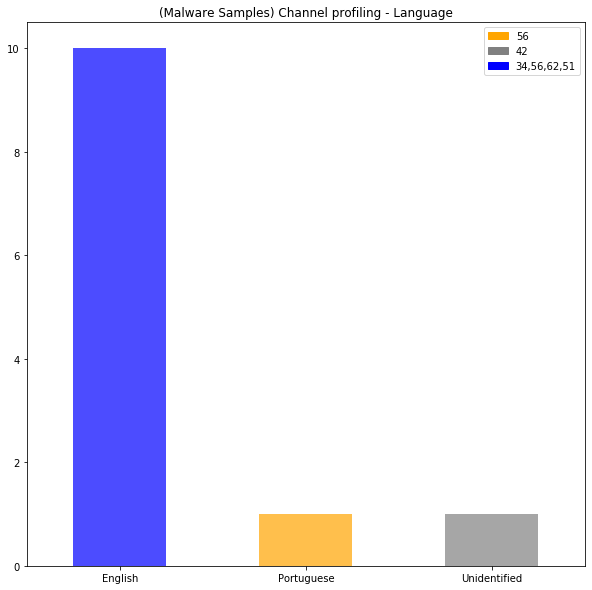

In [34]:
# # corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(10,10))

myplot = corpus_df_mal['lang'].value_counts().plot(kind='bar', color =['blue','orange','gray'], title='(Malware Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches
POR = mpatches.Patch(color='orange', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'Portuguese']['pcap'])))
UN = mpatches.Patch(color='gray', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'Unidentified']['pcap'])))
ENG = mpatches.Patch(color='blue', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'English']['pcap'])))
myplot.legend(handles=[POR,UN,ENG])

plt.xticks(rotation=0)

## Benign Samples

Compute message corpus per each channels

In [117]:
corpus_df_benign = pd.DataFrame(columns=['pcap','corpus','lang'])
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        corpus = load_corpus(logs[channel], ln)
        corpus_df_benign = corpus_df_benign.append({'pcap': ln, 'channel': channel, 'corpus': corpus}, ignore_index=True)

Detect language

In [118]:
for i, c in corpus_df_benign.iterrows():
    pcap = c['pcap']
    text = " ".join(c['corpus'])
    lang = "Unidentified"
    if len(text) > 2:
        code = TextBlob(text).detect_language()
        lang = pycountry.languages.get(alpha_2=code).name
    corpus_df_benign.iloc[i]['lang'] =  lang

df_benign['lang'] = corpus_df_benign['lang']
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang
0,irc1,#worldchat,201,201,0.022353,689.0,English
1,irc1,#amigacs,6,6,0.001194,13.0,Czech
2,irc1,#sscait,1,1,0.000065,44.0,English
3,irc1,#networker,70,70,0.013757,820.0,English
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech


### Plotbar - channels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

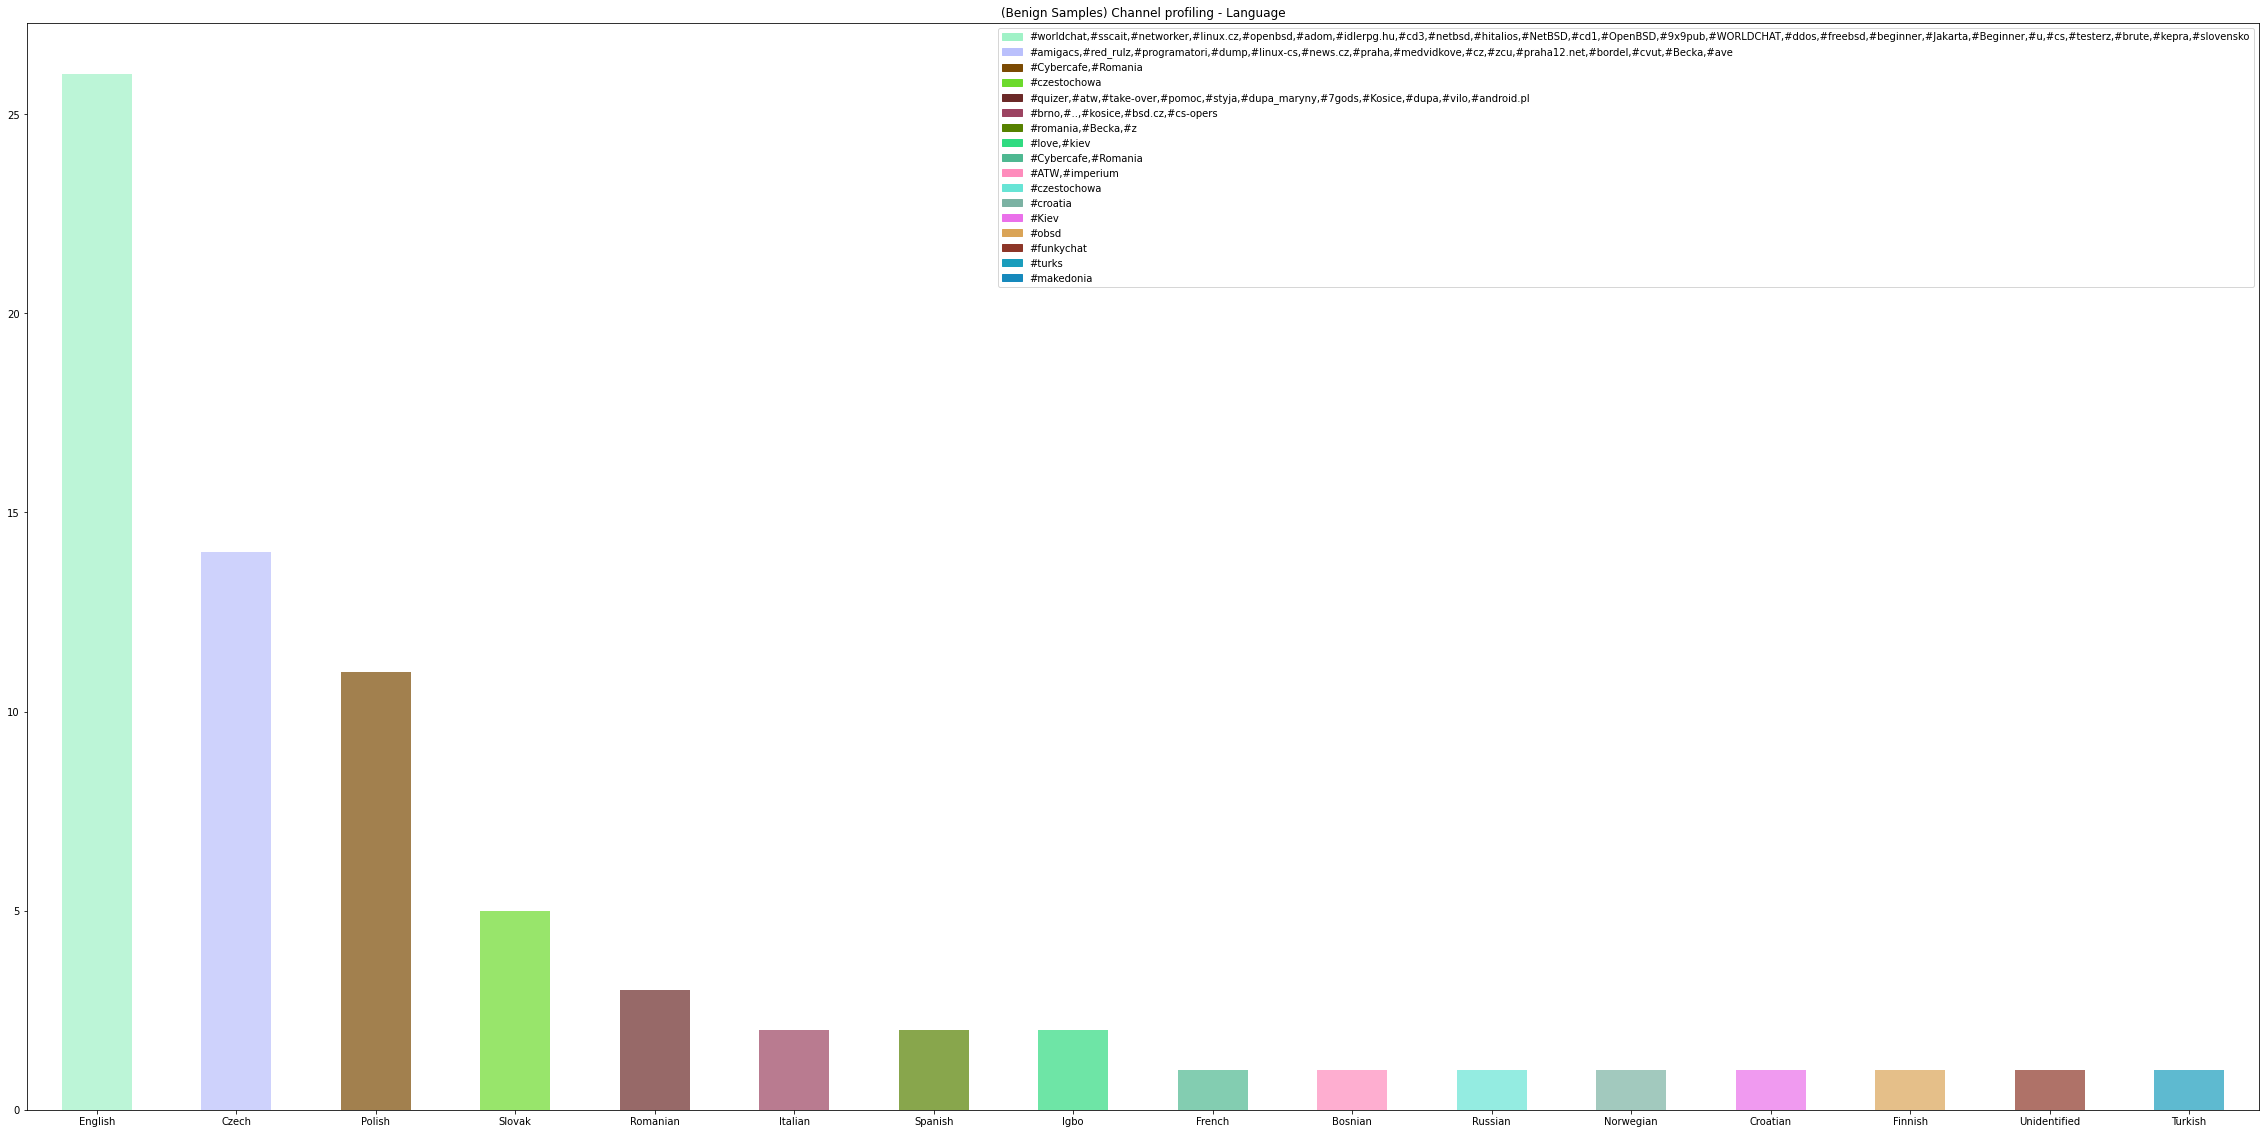

In [42]:
import random
# corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(40,20))
rgb = [(random.random(), random.random(), random.random()) for i in range(corpus_df_benign.shape[0])]
langs = ['English', 'Czech', 'Spanish', 'French', 'Polish','Slovak',
         'Romanian', 'Italian', 'Spanish', 'Igbo', 'French','Bosnian',
         'Russian', 'Norwegian', 'Finnish', 'Turkish', 'Unidentified']
myplot = corpus_df_benign['lang'].value_counts().plot(kind='bar', color=rgb, title='(Benign Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches

handle_arr = []
for c, lang in zip(rgb, langs):
    h = mpatches.Patch(color=c, label= ",".join(list(corpus_df_benign[corpus_df_benign['lang'] == lang]['channel'])))
    handle_arr.append(h)

myplot.legend(handles=handle_arr)

plt.xticks(rotation=0)

### Plotbar - pcaps

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

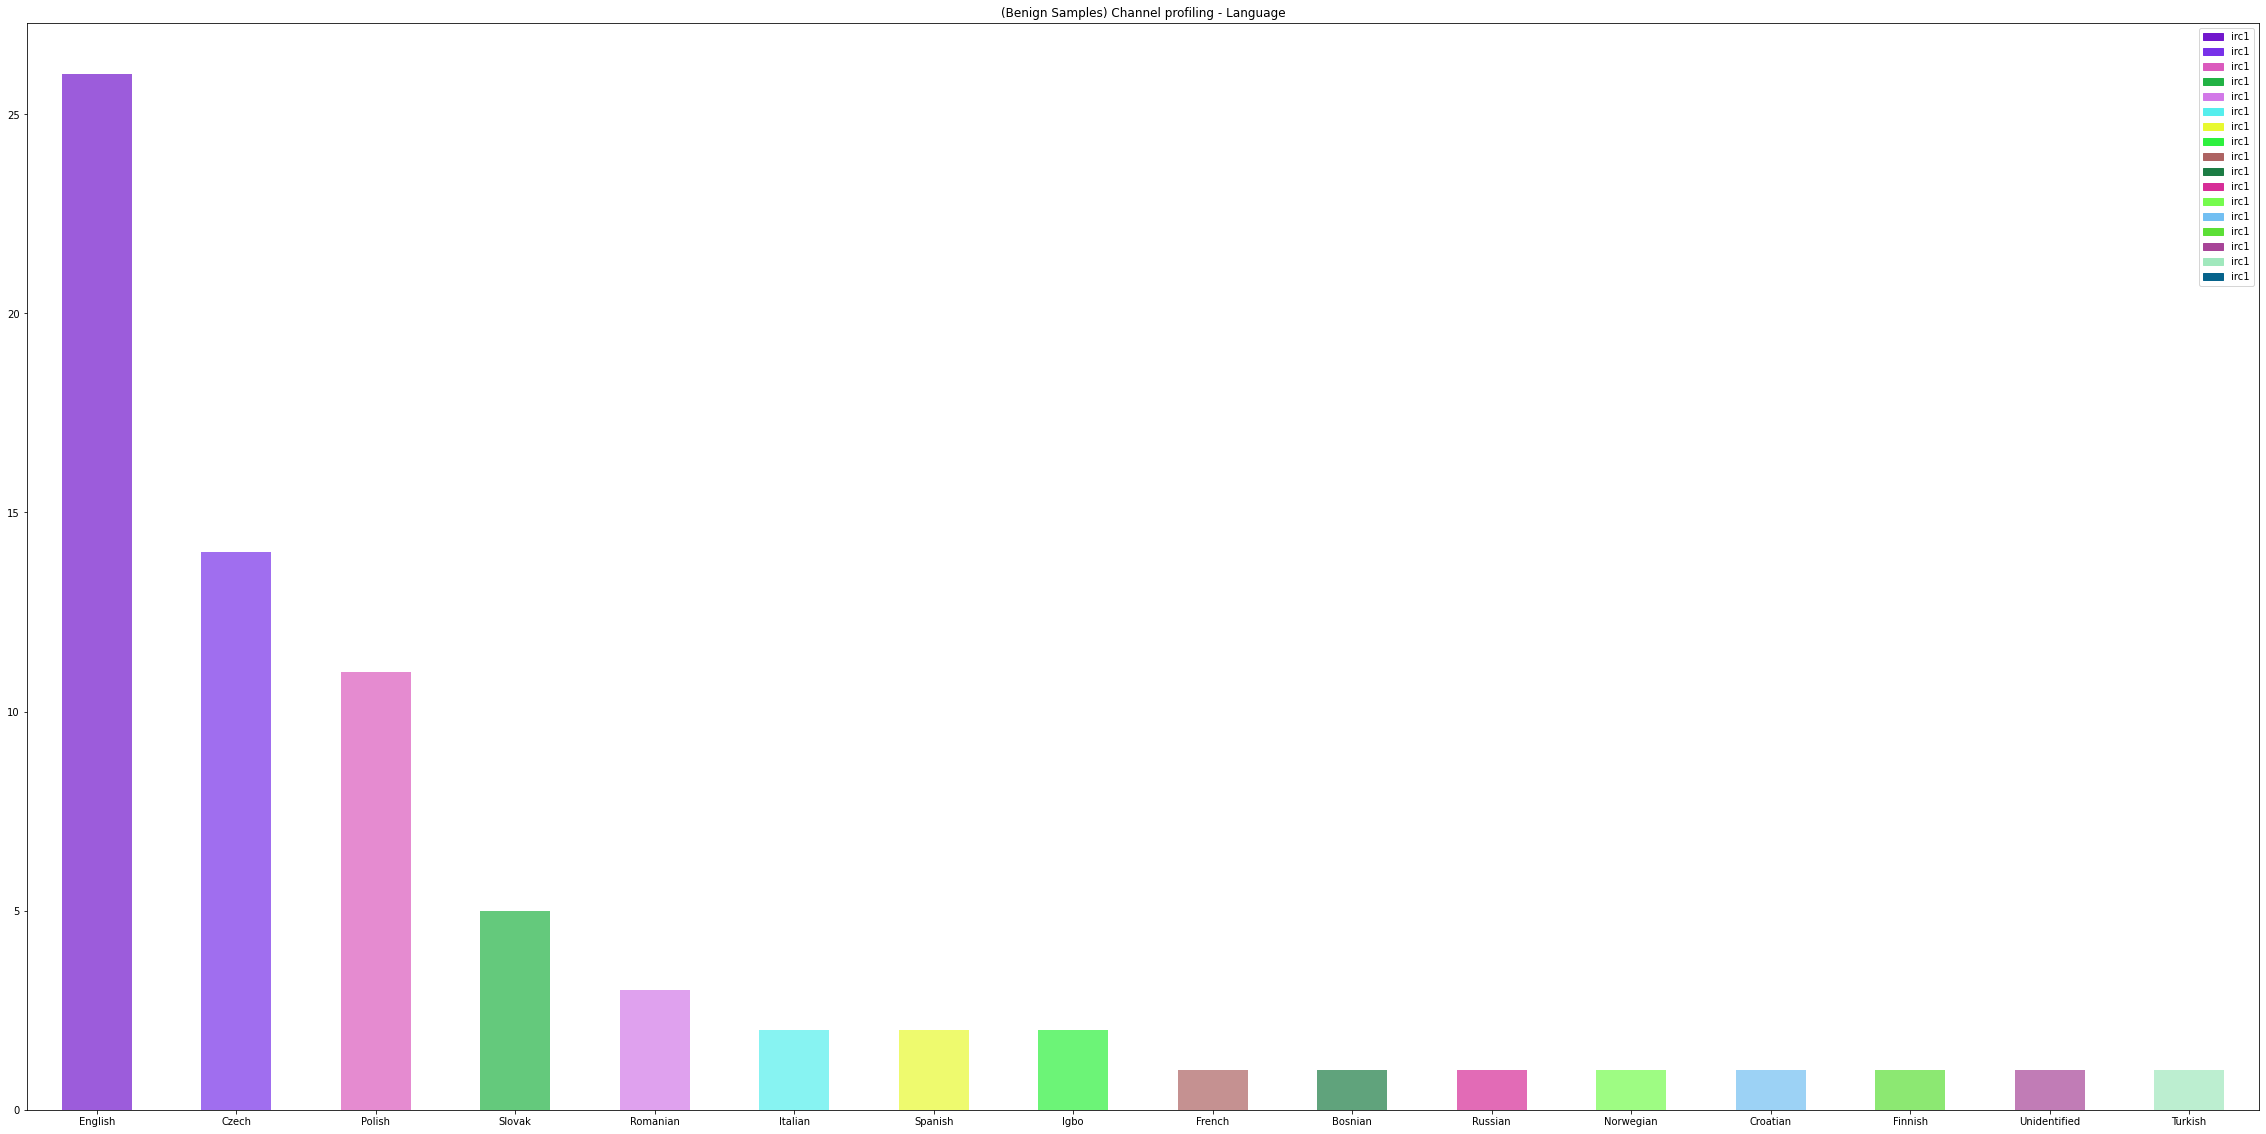

In [47]:
# corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(40,20))
rgb = [(random.random(), random.random(), random.random()) for i in range(corpus_df_benign.shape[0])]
langs = ['English', 'Czech', 'Spanish', 'French', 'Polish','Slovak',
         'Romanian', 'Italian', 'Spanish', 'Igbo', 'French','Bosnian',
         'Russian', 'Norwegian', 'Finnish', 'Turkish', 'Unidentified']
myplot = corpus_df_benign['lang'].value_counts().plot(kind='bar', color=rgb, title='(Benign Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches

handle_arr = []
for c, lang in zip(rgb, langs):
    h = mpatches.Patch(color=c, label= ",".join(set(corpus_df_benign[corpus_df_benign['lang'] == lang]['pcap'])))
    handle_arr.append(h)

myplot.legend(handles=handle_arr)

plt.xticks(rotation=0)

## Message periodicity

In [96]:
def compute_channel_periodicity(communication):
    """
    using Fast Fourier Transform to compute periodicity of messages in sessions
    @:return value in [0,1] interval - 0 means that messages are not periodic at all
    """

    if len(communication) < 3:
        return None

    t = list(map(lambda x: x['ts'].timestamp(), communication))
    td = np.asarray(list(map(lambda x: x[0] - x[1], zip(t[1:], t))))
    fft_res = np.absolute(np.fft.fft(td))
    T = fft_res.argmax() + 2

    rng_size = int(len(td) / T)
    td_T = [td[x * T:x * T + T] for x in range(rng_size)]
    td_T_avg = np.mean(td_T, 0)
    # ||td_t - td_avg ||2 / ||td_t||
    td_nmse = np.linalg.norm(td_T - td_T_avg) / np.linalg.norm(td_T)

    return 1 - td_nmse

### Malicious samples

In [97]:
per_arr = []
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        per_arr.append(compute_channel_periodicity(logs[channel]))
df_mal['msg_periodicity'] = per_arr
df_mal.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max
0,34,##Summit,46.579578,27.772919,English,0.015128,0.015128,8.103709,6,NaN,31
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2
2,51,#007,28.437374,15.612790,English,0.025560,0.025560,4.820940,3,1.0,12
3,51,#all,25.240929,19.280299,English,0.002190,0.002190,4.278526,4,2462.0,7
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2


### Benign Samples

In [119]:
per_arr = []
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        per_arr.append(compute_channel_periodicity(logs[channel]))

df_benign['msg_periodicity'] = per_arr
df_benign.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511


## Message Frequency

In [120]:
def get_message_frequency(logs):
    if len(logs) < 2:
        return None
    t = list(map(lambda x: x['ts'].timestamp(), logs))
    try:
        return len(t)/(t[-1]-t[0])
    except ZeroDivisionError:
        return None

### Malicious Samples

In [122]:
freq_arr = []
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        freq_arr.append(get_message_frequency(logs[channel]))
df_mal['msg_frequency'] = freq_arr
df_mal.head()

,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2


### Benign Samples

In [123]:
freq_arr = []
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        freq_arr.append(get_message_frequency(logs[channel]))
df_benign['msg_frequency'] = freq_arr
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511


## Special characters

In [124]:
def get_spec_chars_mean(logs):
    word_ch = list(chain.from_iterable(map(lambda x: x['msg'].split(), logs)))
    word_spec = map(lambda x: "".join(re.findall(r'[^A-Za-z]',x)), word_ch)
    spec_chars_count = sum(map(len, word_spec))
    chars_total_count = sum(map(len, word_ch))
    return spec_chars_count/chars_total_count

### Malicous Samples

In [125]:
spec_chars_arr = []
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        spec_chars_arr.append(get_spec_chars_mean(logs[channel]))
        
df_mal['spec_chars_mean'] = spec_chars_arr
df_mal.head()

,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max,spec_chars_mean
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31,0.290818
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2,0.000000
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12,0.486271
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7,0.599392
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2,0.394054


### Benign Samples

In [126]:
spec_chars_arr = []
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        spec_chars_arr.append(get_spec_chars_mean(logs[channel]))
        
df_benign['spec_chars_mean'] = spec_chars_arr
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity,spec_chars_mean
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571,0.089418
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616,0.174760
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539,0.093750
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000,0.076569
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511,0.089700


## Word entropy

In [127]:
def get_word_entropy(logs):
    if len(logs) == 0:
        return None
    
    msg_word_count = defaultdict(lambda : 0)
    comm2 = []
    for log in logs:
        msg_words = log['msg'].split()
        for word in msg_words:
            msg_word_count[word] += 1

    _wordcounts = list(msg_word_count.values())
    p = _wordcounts / np.sum(_wordcounts)
    msg_word_entropy = -np.sum(p * np.log2(p))
    return msg_word_entropy

### Malicous Samples

In [128]:
word_entropy_arr = []
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        word_entropy_arr.append(get_word_entropy(logs[channel]))

df_mal['word_entropy'] = word_entropy_arr
df_mal.head()

,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max,spec_chars_mean
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31,0.290818
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2,0.000000
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12,0.486271
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7,0.599392
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2,0.394054


### Benign Samples

In [129]:
word_entropy_arr = []
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        word_entropy_arr.append(get_word_entropy(logs[channel]))

df_benign['word_entropy'] = word_entropy_arr
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity,spec_chars_mean,word_entropy
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571,0.089418,10.524316
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616,0.174760,10.192377
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539,0.093750,4.637199
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000,0.076569,10.312721
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511,0.089700,9.232857


## Channel - Active Users

In [130]:
def get_active_users(logs):
    active_users = set(map(lambda x: x['source'], logs))
    return len(active_users)

### Malicous Samples

In [131]:
active_users_arr = []
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        active_users_arr.append(get_active_users(logs[channel]))

df_mal['active_users'] = active_users_arr
df_mal.head()

,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max,spec_chars_mean
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31,0.290818
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2,0.000000
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12,0.486271
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7,0.599392
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2,0.394054


### Benign Samples

In [132]:
active_users_arr = []
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        active_users_arr.append(get_active_users(logs[channel]))
        

df_benign['active_users'] = active_users_arr
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity,spec_chars_mean,word_entropy
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571,0.089418,10.524316
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616,0.174760,10.192377
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539,0.093750,4.637199
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000,0.076569,10.312721
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511,0.089700,9.232857


## Network Info - Number of Services

In [133]:
def get_num_services(logs):
    try:
        num_services = list(map(lambda x: x['services'], logs))
        return max(num_services)
    except:
        return None

### Malicious Samples

In [137]:
num_services_arr = []
for ln, l in zip(log_names_mal, logs_networkinfo_mal):
    rows = df_mal[df_mal['pcap'] == ln]
    df_mal[df_mal['pcap'] == ln]['network_info-num_users'] = get_num_services(l)

df_mal.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max,spec_chars_mean
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31,0.290818
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2,0.000000
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12,0.486271
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7,0.599392
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2,0.394054


### Benign Samples

In [138]:
num_services_arr = []
for ln, l in zip(log_names_benign, logs_networkinfo_benign):
    df_benign[df_benign['pcap'] == ln]['network_info-num_users'] = get_num_services(l)
    
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity,spec_chars_mean,word_entropy
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571,0.089418,10.524316
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616,0.174760,10.192377
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539,0.093750,4.637199
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000,0.076569,10.312721
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511,0.089700,9.232857


## Network Info - Number of Users

In [139]:
def get_num_users(logs):
    try:
        num_services = list(map(lambda x: x['users'], logs))
        return max(num_services)
    except:
        return None

### Malicious Samples

In [140]:
num_users_arr = []
for ln, l in zip(log_names_mal, logs_networkinfo_mal):
    df_mal[df_mal['pcap'] == ln]['network_info-num_users'] = get_num_users(l)
    
df_mal.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max,spec_chars_mean
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31,0.290818
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2,0.000000
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12,0.486271
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7,0.599392
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2,0.394054


### Benign Samples

In [148]:
num_users_arr = []
for ln, l in zip(log_names_benign, logs_networkinfo_benign):
    df_benign[df_benign['pcap'] == ln]['network_info-num_users'] = get_num_users(l)
    
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity,spec_chars_mean,word_entropy
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571,0.089418,10.524316
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616,0.174760,10.192377
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539,0.093750,4.637199
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000,0.076569,10.312721
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511,0.089700,9.232857


## One-channel users Ratio

In [ ]:
def compute_num_channels(user, users_per_channels):
    count = 0
    for ch in users_per_channels.keys():
        if user in users_per_channels[ch]:
            count += 1
    return count

### Malicious Samples

In [159]:
onechannel_users_arr = []
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    users = set()
    users_channel_count = {}
    users_per_channel = {}
    for channel in logs.keys():
        users_per_channel[channel] = set(map(lambda x: x['source'], logs[channel]))
        users = users.union(users_per_channel[channel])
    
    for u in users:
        users_channel_count[u] = compute_num_channels(u, users_per_channel)
    
    for channel in logs.keys():
        onechannel_users_count = 0
        for u in users_per_channel[channel]:
            if users_channel_count[u] == 1:
                onechannel_users_count += 1
        onechannel_ratio = 0
        if len(users_per_channel[channel]):
            onechannel_ratio = onechannel_users_count/len(users_per_channel[channel])
        onechannel_users_arr.append(onechannel_ratio)

df_mal['onechannel_users_ratio'] = onechannel_users_arr
df_mal.head()

,pcap,channel,lev_dist_mean,lev_dist_std,lang,msg_periodicity,msg_frequency,word_entropy,active_users,num_services,users_join_max,spec_chars_mean,onechannel_users_ratio
0,34,##Summit,46.579578,27.772919,English,0.015128,0.001449,8.103709,6,NaN,31,0.290818,1.00
1,42,#Runz,NaN,NaN,Unidentified,NaN,NaN,-0.000000,1,NaN,2,0.000000,1.00
2,51,#007,28.437374,15.612790,English,0.025560,0.000189,4.820940,3,1.0,12,0.486271,0.00
3,51,#all,25.240929,19.280299,English,0.002190,0.002409,4.278526,4,2462.0,7,0.599392,0.25
4,51,#kz,33.619459,33.149611,English,NaN,NaN,5.244206,2,233.0,2,0.394054,0.00


### Benign Samples

In [153]:
onechannel_users_arr = []
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    users = set()
    users_channel_count = {}
    users_per_channel = {}
    for channel in logs.keys():
        users_per_channel[channel] = set(map(lambda x: x['source'], logs[channel]))
        users = users.union(users_per_channel[channel])
    
    for u in users:
        users_channel_count[u] = compute_num_channels(u, users_per_channel)
    
    for channel in logs.keys():
        onechannel_users_count = 0
        for u in users_per_channel[channel]:
            if users_channel_count[u] == 1:
                onechannel_users_count += 1
        onechannel_ratio = 0
        if len(users_per_channel[channel]):
            onechannel_ratio = onechannel_users_count/len(users_per_channel[channel])
        onechannel_users_arr.append(onechannel_ratio)

df_benign['onechannel_users_ratio'] = onechannel_users_arr
df_benign.head()

,pcap,channel,active_users,num_services,msg_frequency,users_join_max,lang,msg_periodicity,spec_chars_mean,word_entropy,onechannel_users_ratio
0,irc1,#worldchat,201,201,0.022353,689.0,English,0.012571,0.089418,10.524316,0.945274
1,irc1,#amigacs,6,6,0.001194,13.0,Czech,0.008616,0.174760,10.192377,0.833333
2,irc1,#sscait,1,1,0.000065,44.0,English,0.434539,0.093750,4.637199,0.000000
3,irc1,#networker,70,70,0.013757,820.0,English,1.000000,0.076569,10.312721,0.971429
4,irc1,#red_rulz,11,11,0.003070,27.0,Czech,0.003511,0.089700,9.232857,0.818182
